In [291]:
import pandas as pd
import matplotlib as plt

df = pd.read_csv('csv\\2603_20220127191321.csv', encoding='ANSI')

In [292]:

def inp(df,r,i,stock,money):
    stock +=1
    df['stock'].iloc[i] = stock
    
    r = r-df.iloc[i,1]*1000 
    money = money -df.iloc[i,1]*1000
    df['trade'].loc[i]= -df.iloc[i,1]*1000 
    
    return (r,stock,money)

def outp(df,r,price,i,stock,money):
    
      
    
    r = r+stock*df.iloc[i,price]*1000 
    money = money + stock*df.iloc[i,price]*1000 
    df['account'].iloc[i] = money 
    df['ret'].iloc[i] = r
    df['trade'].iloc[i]= stock*df.iloc[i,price]*1000
    
    
    stock = 0 
    r = 0
    df['stock'].iloc[i] = stock 
    return (r,stock,money)
def MA(s,l,df):
    df['ma_s']=df.iloc[:,4].rolling(s).mean() 
    df['ma_l']=df.iloc[:,4].rolling(l).mean() 
    # 新增 MA 交易訊號欄
    df['ma_sign']=0
    # 設定黃金交叉訊號出現時， 標示=1
    
    df.loc[(df.ma_s.shift(1) < df.ma_l.shift(1)) &(df.ma_s > df.ma_l),'ma_sign'] =1
    # 設定死亡交叉訊號出現時，標示=-1
    df.loc[(df['ma_s'].shift(1) > df['ma_l'].shift(1)) &(df['ma_s'] < df['ma_l']),'ma_sign'] = -1

def RedK(df,hp,i):
    p = 100*(df['收盤價'].iloc[i]-df['開盤價'].iloc[i]) / df['開盤價'].iloc[i] 
   
    if (p > hp) and ( df['收盤價'].iloc[i]>df['ma_s'].iloc[i] ) :
        df['Red_sign'].iloc[i]=1
        return 1
    
def sign(df,i):
    if (df['ma_sign'].iloc[i] == -1) or (df['Red_sign'].iloc[i-1] == 1) or (df['rsi_sign'].iloc[i]== -1):
        df['outp_sign'].iloc[i]= 1
    if (df['ma_sign'].iloc[i] == 1) or (RedK(df,4,i) == 1):
        df['inp_sign'].iloc[i]= 1
        



def RSI(d,df):

    x = df.iloc[:,4].diff() 

    df['rsi'] = 100*x.where(x>0,0).rolling(10).mean() / x.where(x>0,-x).rolling(10).mean()
   
    df['rsi_sign'] = 0
    
    df.loc[(df['rsi']<30),'rsi_sign'] = 1
  
    df.loc[(df['rsi']>70),'rsi_sign'] = -1

def stop(df,lsp,r,i,stock):
   
    mm = r +df.iloc[i,4]*1000 
    mp = mm/(r) 
 
    if  (mp<lsp) :
        
        (r,stock,money)=outp(df,r,1,i+1,stock,money)
    return(r,stock,money)

def result_F(df):
    
    last = df['cus'].iloc[-1]
    
    count = df['inp_sign'][df['inp_sign']!=0].count()+df['outp_sign'][df['outp_sign']!=0].count() #部位紀錄中不等於0的計數
    
    def maxdrawdown(s):
        s = s.cummax() - s 
        return(s.max())
    
    mdd = maxdrawdown(df['cus'])

    if count == 0:
        w=0
    else:
        w = df['account'][df['account']>0].count()/count
    
    result =pd.DataFrame({
            '最後報酬':[last],
            '交易次數':[count],
            '最大回檔':[mdd],
            '勝率':[w]
    })
    return result
#輸出回測結果至Excel檔案
#name為指定輸出Excel檔案名稱，df為輸出資料內容，result為績效指標
#K為保留K線數，L為總資料筆數
def out_excel(name,df,result,K,L):
    writer = pd.ExcelWriter('D:\\backtesting\\report\\' + name +'.xlsx')
    df.to_excel(writer,'0') #將df資料輸出到'0' 工作表
    result.to_excel(writer,'result') #將 result 資料輸出到'result'工作表
    #將 df['cus']資料輸出到'result' 工作表，指定第 5 欄輸出
    df['cus'].to_excel(writer,'result',startcol=5)
    workbook = writer.book
    chart = workbook.add_chart({'type':'line'}) #指定格式建立圖形物件
    chart.add_series({'values':'='+'result'+'!$G$'+str(K+1)+':$G$'+str(L+1),'name':'cus'})
    worksheet = writer.sheets['result']#設定寫出至result工作表
    worksheet.insert_chart('H2',chart)#將圖形插入到工作中
    writer.save()
#進行買賣計算
MA(5,20,df)
RSI(14,df)
K=50 
L=len(df) 
money=500000
b=0 
stock=0
df['stock']=0
df['inp_sign']=0 
df['outp_sign']=0
df['ret']=0
df['trade']=0
df['Red_sign']=0
df['account']=0




In [293]:
#由於序號從0開始。迴圈從第k-1筆記錄開始執行
for i in range(K-1,L):
    
    sign(df,i)
    df['account'].iloc[i]=money
    df['stock'].iloc[i]=stock
 
    if i < L-1:
        
            
            if df['inp_sign'].iloc[i] == 1 and df['account'].iloc[i] >= df['開盤價'].iloc[i]:
                    (r,stock,money)=inp(df,r,i+1,stock,money)



            elif df['outp_sign'].iloc[i] == 1 and df['stock'].iloc[i-1] > 0:
                    
                    (r,stock,money)=outp(df,r,1,i+1,stock,money)

            

    elif i == L-1:
 
        if stock != 0:

            (r,stock,money)=outp(df,r,4,i,stock,money)


C:\Users\88698\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

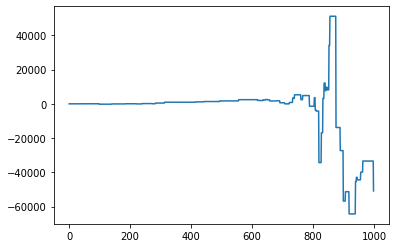

In [294]:
# 計算累計損益
df['cus']=df['ret'].cumsum() 
df['cus'].plot() 

In [295]:
#計算各項策略績效指標
result = result_F(df)
#輸出績效至Excel
out_excel('Report',df,result,K,L)

In [296]:
pd.set_option('display.max_rows', df.shape[0]+1)
df

,日 期,開盤價,最高價,最低價,收盤價,成交量,均價[5],均價[20],均價[60],均價[120],...,rsi,rsi_sign,stock,inp_sign,outp_sign,ret,trade,Red_sign,account,cus
0,20171227,16.35,16.70,16.35,16.65,19058,0,0,0,0,...,NaN,0,0,0,0,0.0,0.0,0,0,0.0
1,20171228,16.75,16.75,16.55,16.55,13346,0,0,0,0,...,NaN,0,0,0,0,0.0,0.0,0,0,0.0
2,20171229,16.60,16.70,16.35,16.35,19720,0,0,0,0,...,NaN,0,0,0,0,0.0,0.0,0,0,0.0
3,20180102,16.55,17.95,16.55,17.95,137433,0,0,0,0,...,NaN,0,0,0,0,0.0,0.0,0,0,0.0
4,20180103,18.30,18.50,17.55,17.70,145335,17.04,0,0,0,...,NaN,0,0,0,0,0.0,0.0,0,0,0.0
5,20180104,17.70,18.15,17.40,18.15,91627,17.34↑,0,0,0,...,NaN,0,0,0,0,0.0,0.0,0,0,0.0
6,20180105,18.45,18.75,18.30,18.70,159120,17.77↑,0,0,0,...,NaN,0,0,0,0,0.0,0.0,0,0,0.0
7,20180108,18.50,18.60,18.10,18.40,50405,18.18↑,0,0,0,...,NaN,0,0,0,0,0.0,0.0,0,0,0.0
8,20180109,18.40,18.40,18.10,18.20,23591,18.23↑,0,0,0,...,NaN,0,0,0,0,0.0,0.0,0,0,0.0
9,20180110,18.20,18.25,17.70,17.75,36192,18.24↑,0,0,0,...,NaN,0,0,0,0,0.0,0.0,0,0,0.0
